# Load Data files and Import Python Libraries

In [40]:
import numpy as np

import pandas as pd

import os

from sklearn.feature_selection import RFE

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression

#import MatPlotLib
import matplotlib as mpl 

#Import PyPlot in MatPlotLib
import matplotlib.pyplot as plt 

#Import SciKitLearn decomposition PCA library
from sklearn.decomposition import PCA

#Import SciKitLearn dataset 
from sklearn import datasets as ds

#Allows for meterics to be found after Logistic Regression
from sklearn import metrics as mt

#Create KFolds for CV_Object
from sklearn.model_selection import StratifiedKFold

#Creates Standard Scaler Variables
from sklearn.preprocessing import StandardScaler

#Seaborn 
import seaborn as sb

directory = '//users/cmirwin/desktop/Capstone/'

if not os.path.exists(directory):
    os.makedirs(directory)

#Import Team Info
dfGameData = pd.read_csv(directory + 'GameData.csv', sep='|')

dfGameData.head()

,GameID,HomeTeam,AwayTeam,GameWinner,GameLoser,ScoreHome,ScoreAway,HomeFirstDowns,HomePassingYards,HomePenaltyCnt,...,WindChill,HeatIndex,HomePassYardsPerAttempt,HomePassingCompPct,AwayPassYardsPerAttempt,AwayPassingCompPct,HomeRushYardsPerAttempt,AwayRushYardsPerAttempt,HomeTeamWin,Degrees
0,1,PIT,TEN,PIT,TEN,13,10,19,321,6,...,NaN,NaN,9.727273,0.767442,10.636364,0.628571,1.565217,3.440000,1,67.5
1,2,ATL,MIA,ATL,MIA,19,7,19,213,4,...,NaN,NaN,9.681818,0.611111,7.761905,0.700000,2.518519,4.363636,1,90.0
2,3,BAL,KC,BAL,KC,38,24,32,303,8,...,NaN,NaN,11.653846,0.604651,9.937500,0.666667,4.829268,1.705882,1,0.0
3,4,CAR,PHI,PHI,CAR,10,38,14,83,5,...,NaN,81.0,5.928571,0.411765,4.823529,0.586207,2.866667,5.781250,0,22.5
4,5,CIN,DEN,DEN,CIN,7,12,16,221,4,...,NaN,NaN,10.523810,0.636364,13.352941,0.607143,3.185185,3.750000,0,67.5


 # Create Dummy Variables for Dataset

In [112]:
#Create new DataFrame for PCA
gameDataPCA = dfGameData

dummiesColumnToCreate = ['WindDir', 'Condition','TimeOfDay']

#Create Dummy Variables
for column in dummiesColumnToCreate:
    dummies = pd.get_dummies(gameDataPCA[str(column)]).rename(columns=lambda x: str(column) + '_' + str(x))
    #Join to Dataframe for Model
    gameDataPCA = pd.concat([gameDataPCA, dummies], axis=1)

gameDataPCA.head()
    
#Get columns that are only numeric in nature. 
columnsToDrop = ['HomeTeam', 'AwayTeam', 'GameWinner','GameLoser', 'WindDir', 'Condition','TimeOfDay', 'Date'
                 , 'HomePossTime', 'AwayPossTime']

#Drop Variables
gameDataPCA.drop(columnsToDrop, inplace=True, axis=1)

#Fill in Missing Values with 0
gameDataPCA.fillna(0, inplace=True)



# Feature Selection
## Recursive Feature Elimination

In [117]:
gameDataVariables = gameDataPCA.columns.values.tolist()
y = gameDataPCA['HomeTeamWin']
X=[i for i in gameDataVariables if i not in y]

logreg = LogisticRegression()
rfe = RFE(logreg, 18)
rfe = rfe.fit(gameDataPCA[X], y )

dfColumns = pd.DataFrame(X)

dfRankings = pd.DataFrame(rfe.ranking_)

dfColumnResults =  pd.concat([dfRankings, dfColumns], axis=1, join_axes=[dfRankings.index])

dfColumnResults.columns = ['Value', 'ColumnName']

dfColumnsForModel = dfColumnResults[dfColumnResults['Value'] == 1]

print dfColumnsForModel

    Value        ColumnName
0       1            GameID
1       1         ScoreHome
2       1         ScoreAway
4       1  HomePassingYards
7       1       HomePuntAvg
9       1     HomePuntYards
10      1  HomeRushingYards
11      1    HomeTotalYards
14      1  AwayPassingYards
16      1  AwayPenaltyYards
19      1     AwayPuntYards
20      1  AwayRushingYards
37      1              Year
40      1       NumericDate
41      1              Temp
42      1          DewPoint
44      1          Humidity
60      1           Degrees


## PCA Analysis

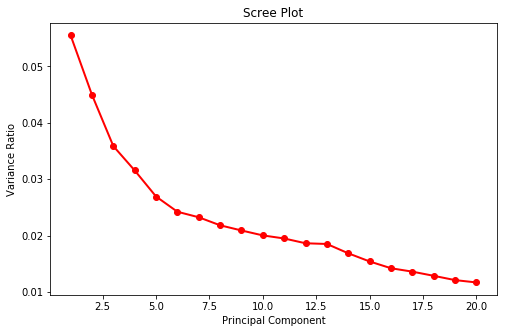

In [114]:
#This section scales the data in order to create a more useable data set
# scale attributes by the training set
stdsclrObj = StandardScaler()

# find scalings for each column that make this zero mean and unit std
#We use the training data to help fit the standard dev
# find scalings for each column that make this zero mean and unit std
stdsclrObj.fit(gameDataPCA) 

# to transform new feature data
# apply to training
gameData_scaled = stdsclrObj.transform(gameDataPCA)

components = 20

pca = PCA(n_components= components)

#Run PCA
# fit data and then transform it
gameData_pca = pca.fit(gameData_scaled).transform(gameData_scaled) 

variance_ratio = pca.explained_variance_ratio_

fig = plt.figure(figsize=(8,5))
#Create 
CompentValues = np.arange(components) + 1
plt.plot(CompentValues, variance_ratio, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.show()

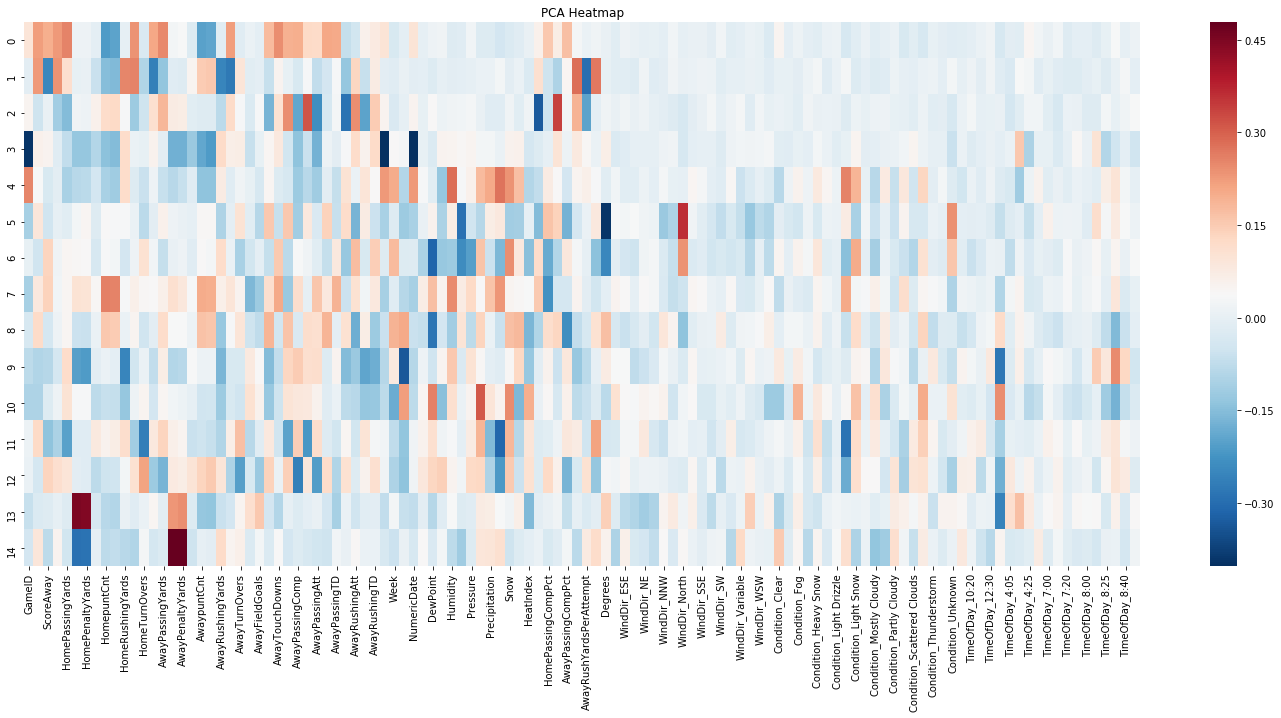

In [115]:
pca_components = pca.components_

compValues = pd.DataFrame(pca_components,columns=gameDataPCA.columns)

#show top 40 vectors due to the analysis 
compValues = compValues[compValues.index < 15]

plt.figure(figsize=(25,10))

plt.title('PCA Heatmap')

sb.heatmap(compValues, cmap = 'RdBu_r', cbar=True)

plt.show()

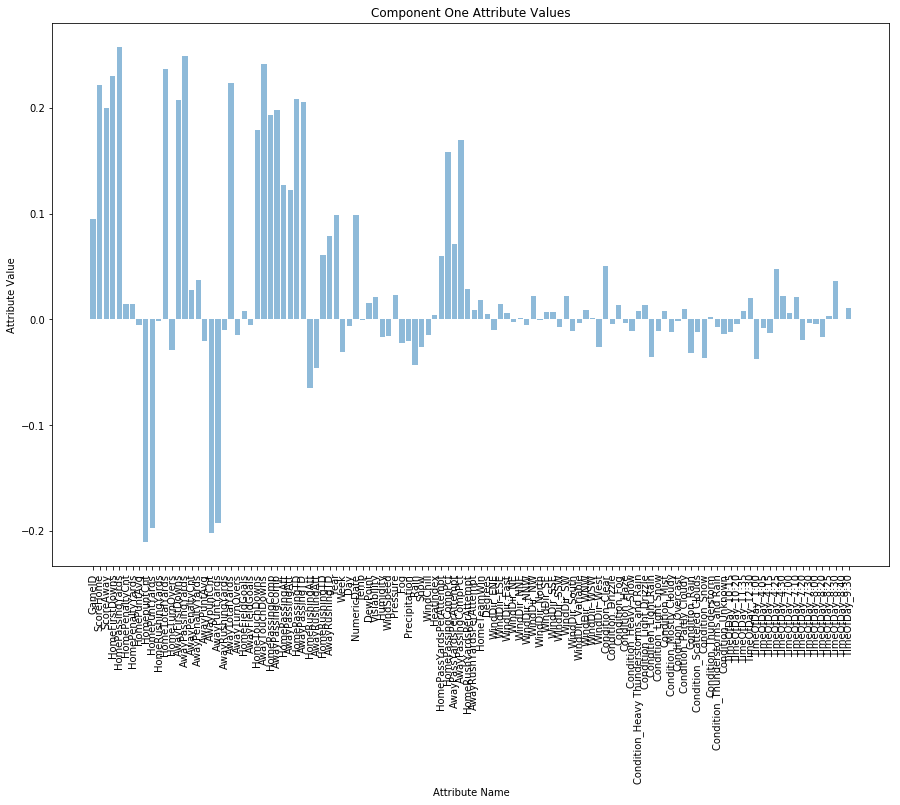

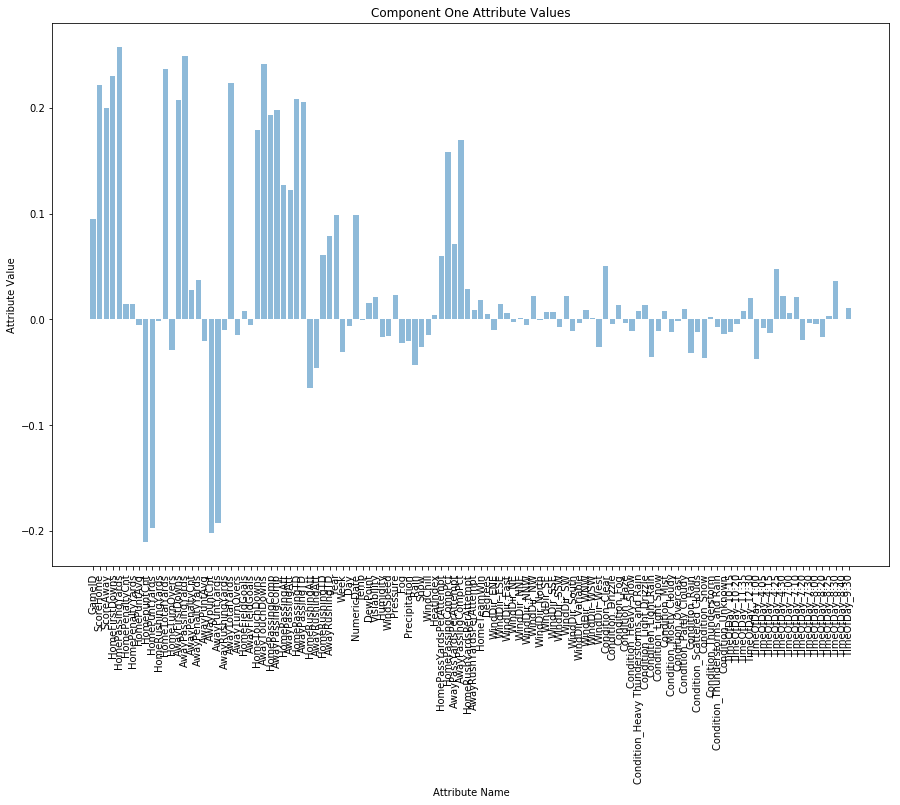

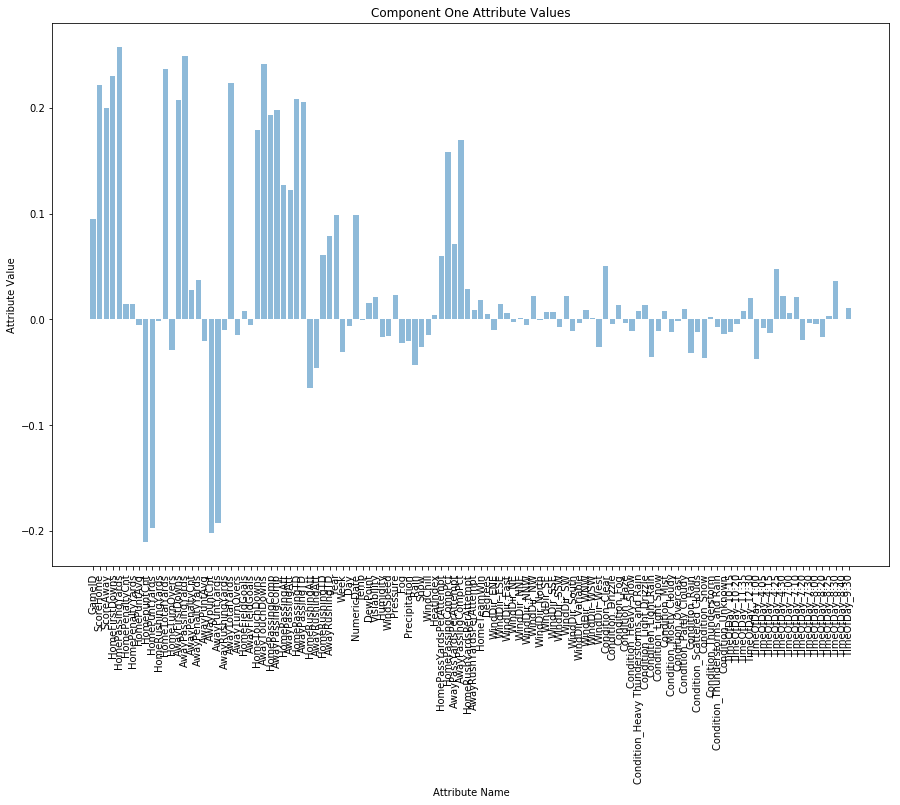

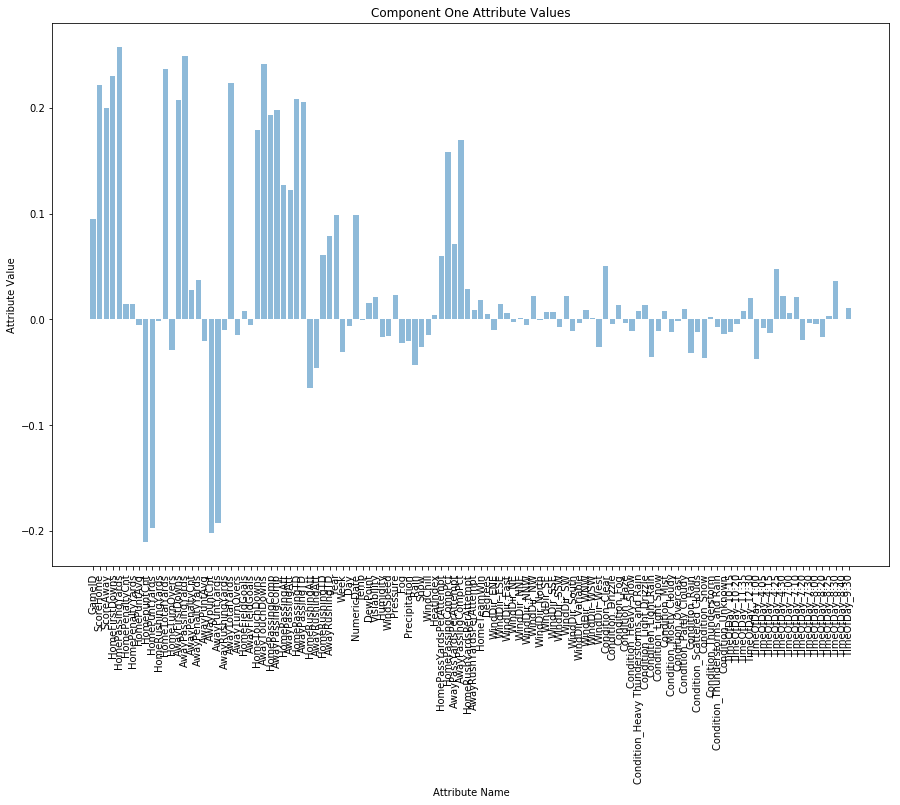

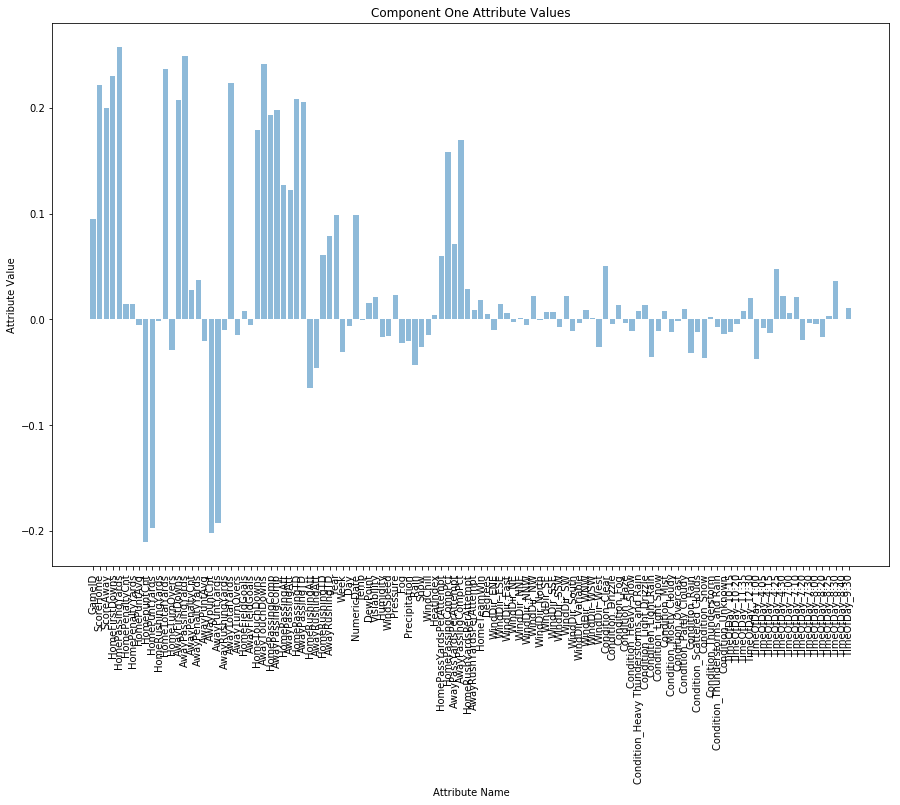

In [128]:
compValuesTransformed = compValues.T

#print (compValuesTransformed[0])

fig = plt.figure(figsize=(15,10))
#Create
objects = compValuesTransformed.index
y_pos = np.arange(len(objects)) + 1
performance = compValuesTransformed[0]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=90)
plt.xlabel('Attribute Name')
plt.ylabel('Attribute Value')
plt.title('Component One Attribute Values')

plt.show()

# Creating Logistic Regression Model
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [149]:
dfPCAValues = pd.DataFrame(performance)

print dfPCAValues

dfPCAValues[]

dfPCAValues.columns = ['Value', 'ColumnName']


                                         0
GameID                            0.094387
ScoreHome                         0.221146
ScoreAway                         0.199425
HomeFirstDowns                    0.230167
HomePassingYards                  0.257079
HomePenaltyCnt                    0.014379
HomePenaltyYards                  0.014684
HomePuntAvg                      -0.005187
HomepuntCnt                      -0.210204
HomePuntYards                    -0.197629
HomeRushingYards                 -0.001302
HomeTotalYards                    0.236202
HomeTurnOvers                    -0.029397
AwayFirstDowns                    0.207036
AwayPassingYards                  0.248524
AwayPenaltyCnt                    0.027953
AwayPenaltyYards                  0.037242
AwayPuntAvg                      -0.020641
AwaypuntCnt                      -0.201783
AwayPuntYards                    -0.192789
AwayRushingYards                 -0.010154
AwayTotalYards                    0.223770
AwayTurnOve

In [123]:


gameDataVariables = gameDataPCA.columns.values.tolist()

y = gameDataPCA['HomeTeamWin']

X = [i for i in gameDataVariables if i not in y]

XforModel = gameDataPCA[X]

logit_model = sm.Logit(y,XforModel)

result = logit_model.fit()

print(performance)

#print(result.summary())


PerfectSeparationError: Perfect separation detected, results not available